In [73]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [2]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


# Get Data Spectra

In [18]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['centre_beta'] < hbeta + 5)*
    (wdtable['centre_beta'] > hbeta - 5)*
    (wdtable['centre_alpha'] > halpha - 5)*
    (wdtable['centre_alpha'] < halpha + 5) * 
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 13000) * 
    (wdtable['TeffH'] < 80000) * 
    (wdtable['subclass'] == 'WD')[:,0].data*
    (wdtable['S2N'] > 2.5)
)
notgoodtable = wdtable[~good]
wdtable = wdtable[good]
len(wdtable)

1188

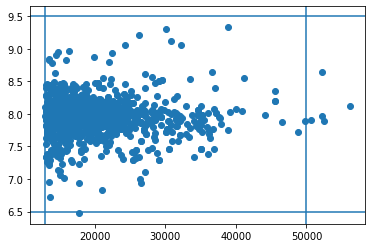

In [19]:
plt.scatter(wdtable['TeffH'],wdtable['loggH'])
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(13000)
plt.axvline(50000)

In [20]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

def rvcorr(spectrum):
    lamgrid = np.arange(4000,8000)
    coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
    coremask = coremask.astype(int)
    trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
    if trans > 5:
        trans = 5;
    elif trans < 5:
        trans = -5;
    else:
        ;
    shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
    return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

100%|██████████| 1188/1188 [01:48<00:00, 10.90it/s]


In [466]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [467]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)








  0%|          | 0/1188 [00:00<?, ?it/s]






  3%|▎         | 37/1188 [00:00<00:03, 367.51it/s]






  6%|▌         | 73/1188 [00:00<00:03, 362.42it/s]






  9%|▉         | 109/1188 [00:00<00:02, 360.70it/s]






 12%|█▏        | 145/1188 [00:00<00:02, 358.90it/s]






 15%|█▌        | 181/1188 [00:00<00:02, 358.82it/s]






 18%|█▊        | 217/1188 [00:00<00:02, 356.35it/s]






 21%|██▏       | 253/1188 [00:00<00:02, 356.25it/s]






 24%|██▍       | 289/1188 [00:00<00:02, 356.94it/s]






 27%|██▋       | 325/1188 [00:00<00:02, 357.24it/s]






 30%|███       | 361/1188 [00:01<00:02, 357.82it/s]






 33%|███▎      | 397/1188 [00:01<00:02, 358.36it/s]






 36%|███▋      | 433/1188 [00:01<00:02, 358.61it/s]






 39%|███▉      | 469/1188 [00:01<00:02, 358.89it/s]






 43%|████▎     | 505/1188 [00:01<00:01, 350.67it/s]






 46%|████▌     | 542/1188 [00:01<00:01, 353.53it/s]






 49%|████▊     | 579/1188 [00:01<00:01, 355.54it/s]






 52%|█████▏    | 615

1188

# Train Generator

In [516]:
sc = StandardScaler()

X = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())
t = normspec
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1,random_state=13)

In [517]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(10,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(10,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_29 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_30 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 3000)              33000     
Total params: 33,140
Trainable params: 33,140
Non-trainable params: 0
_________________________________________________________________
None


In [518]:
epoch = 25000
batch = len(X_train)

history = model.fit(X,t,epochs=epoch,verbose=0,batch_size=batch,validation_data = (X_test,y_test))

In [519]:
model.save('datagen.h5')

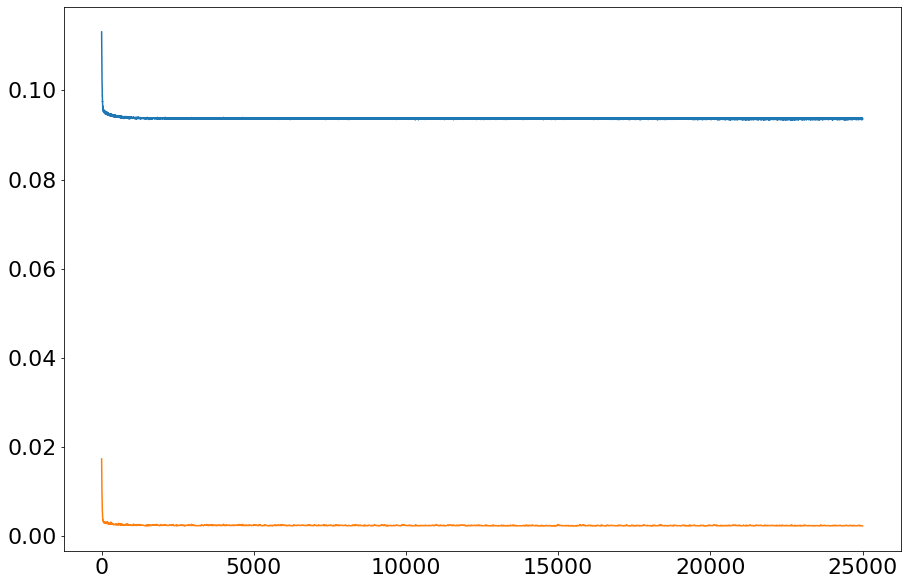

In [520]:
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))

### Evaluate TeFF Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

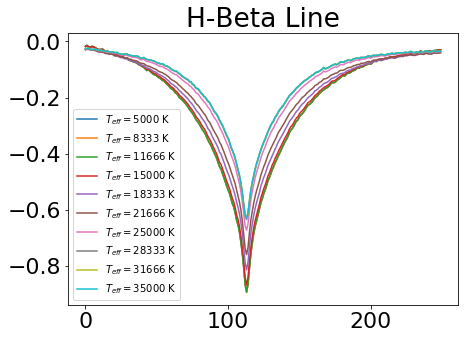

In [521]:
plt.figure(figsize=(7,5))
ts = np.linspace(5000,35000,10)
ls = np.linspace(8,8,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate logg Sensitivity

Text(0.5, 1.0, 'T = 35000 K')

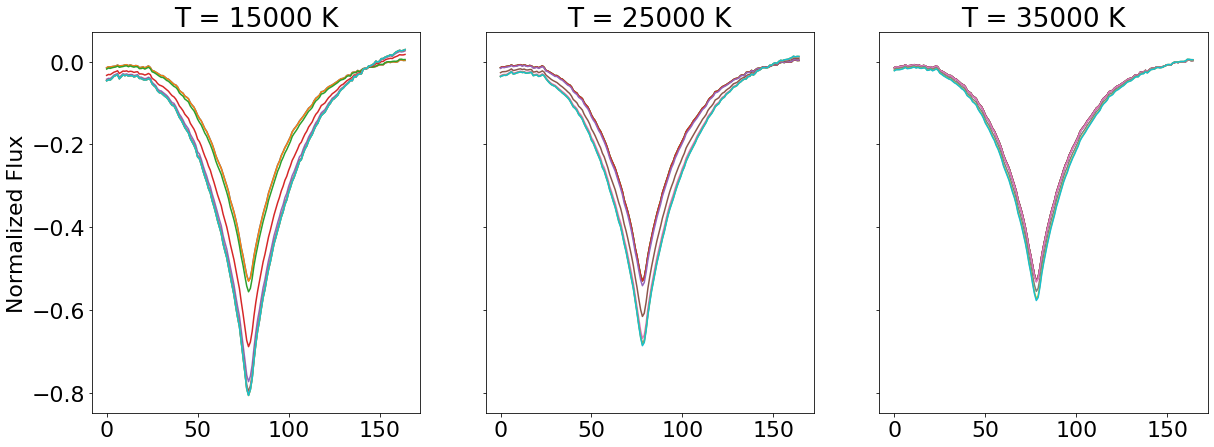

In [522]:
f,axs = plt.subplots(1,3,sharey = True,figsize=(20,7))

ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    axs[0].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

#axs[0].legend(fontsize=8)
axs[0].set_title('T = 15000 K')
axs[0].set_ylabel('Normalized Flux')

ts = np.linspace(25000,25000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    axs[1].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

#axs[1].legend(fontsize=8)
axs[1].set_title('T = 25000 K')

ts = np.linspace(35000,35000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    axs[2].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

#axs[2].legend(fontsize=6)
axs[2].set_title('T = 35000 K')

# plt.subplot(132)
# ts = np.linspace(25000,25000,10)
# ls = np.linspace(6.5,9.5,10)
# samples = sc.transform(np.stack((ts,ls)).transpose())
# gens = model.predict(samples)
# for i in range(len(gens)):
#     plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

# plt.legend(fontsize=8)
# plt.title('T = 25000 K')

# plt.subplot(133)
# ts = np.linspace(35000,35000,10)
# ls = np.linspace(6.5,9.5,10)
# samples = sc.transform(np.stack((ts,ls)).transpose())
# gens = model.predict(samples)
# for i in range(len(gens)):
#     plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

# plt.legend(fontsize=8)
# plt.title('T = 35000 K')

### Evaluate Residuals of Random Control Spectra

Text(0.5, 1.0, 'Sample of Model Residuals')

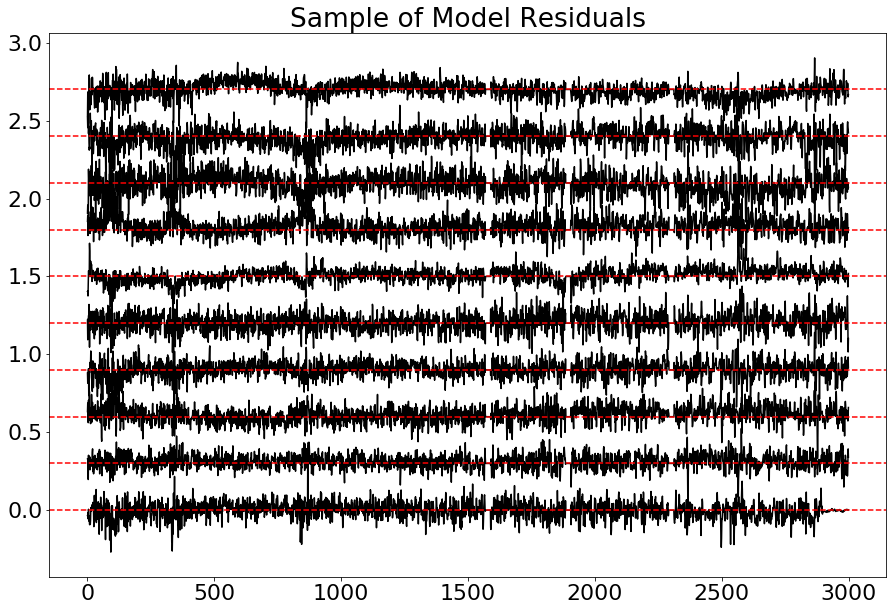

In [525]:
resids = y_test - model.predict(X_test)
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.3*ct,'k')
    plt.axhline(0.3*ct,color='r',linestyle='--')
    ct += 1
plt.title('Sample of Model Residuals')

In [526]:
modelscaling = 1e5

def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    return interpolation.shift(model.predict(label)[0],trans,cval=np.nan)*modelscaling

def chisquare(residual):
    return sum(residual**2)

In [527]:
lamgrid = np.arange(4000,7000)
fitter = lmfit.Model(spectrum_sampler)
params = fitter.make_params(teff = 20000.,logg=8.,trans=0.)
params['teff'].set(min=13000,max=80000)
params['logg'].set(min=6.5,max=9.5)
params['trans'].set(min=-10,max=10,vary=False)

In [528]:
y_
fitoutput = np.zeros((len(y_test),5))

for i in tqdm(range(len(y_test))):
    spec = y_test[i]
    fitoutput[i,0] = int(specnames[i][:-12])
    #params['teff'].set(value=sc.inverse_transform(X_test)[i,0],vary=False)
    result = fitter.fit(spec*modelscaling,params,wl=lamgrid,method="powell",nan_policy='omit',calc_covar=True)
    fitoutput[i,1] = result.params['teff'].value
    fitoutput[i,2] = result.params['teff'].stderr
    fitoutput[i,3] = result.params['logg'].value
    fitoutput[i,4] = result.params['logg'].stderr
    
#     plt.figure(figsize=(7,5))
#     plt.plot(spec*modelscaling)
#     plt.plot(spectrum_sampler(None,result.params['teff'],result.params['logg'],result.params['trans']))
#     plt.show()








  0%|          | 0/1 [00:00<?, ?it/s]






100%|██████████| 1/1 [01:22<00:00, 82.39s/it]

In [529]:
true_labels = sc.inverse_transform(X_test)

Text(0.5, 1.0, 'Data-Driven Generator')

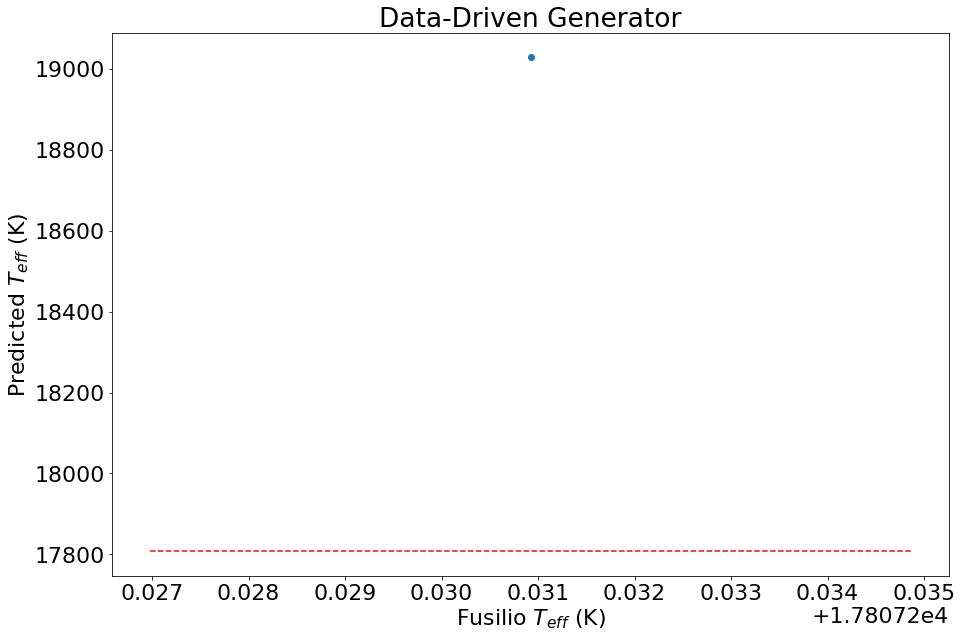

In [530]:
true = true_labels[:,0]
pred = fitoutput[:,1]
f=plt.scatter(true,pred)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Data-Driven Generator')

Text(0.5, 1.0, 'Data-Driven Generator')

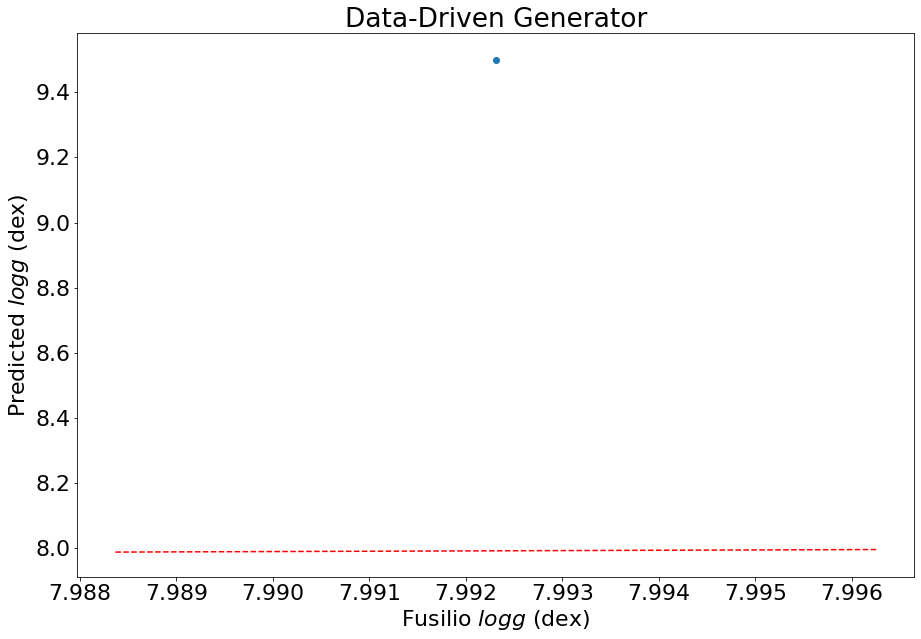

In [531]:
true = true_labels[:,1]
pred = fitoutput[:,3]
f=plt.scatter(true,pred)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $logg$ (dex)')
plt.ylabel('Predicted $logg$ (dex)')
plt.title('Data-Driven Generator')

W0731 20:45:28.218917 47550413538624 corner.py:542] Too few points to create valid contours


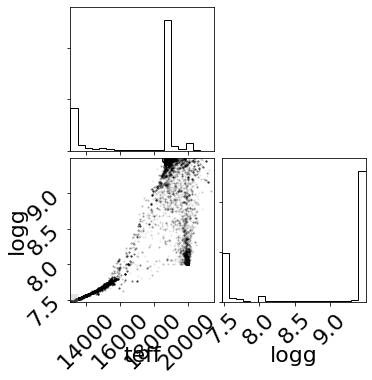

In [532]:
f = corner.corner(result.flatchain)